In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
%pip -q install wbdata
import wbdata
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Helper Functions

def iso3_to_wbname(iso3):
    """
    Convert ISO3 code (e.g., 'EGY') to the World Bank country name
    used inside wbdata DataFrame indexes (e.g., 'Egypt, Arab Rep.').

    If user passes a WB name already, return it unchanged.
    """
    if iso3 is None:
        return None
    if isinstance(iso3, str) and len(iso3) != 3:
        return iso3
    try:
        info = wbdata.get_country(iso3)
        if isinstance(info, list) and len(info) > 0:
            return info[0].get("name", iso3)
    except Exception:
        pass
    return iso3


def country_in_index(df, place):
    """
    Return the actual country key that exists in df.index level 0.

    Why this exists:
    - Some environments end up with country index = WB NAME (common)
    - If you pass ISO3 (EGY), you'll get "No data for country EGY"
      unless we map it to the WB name.
    """
    lvl0 = df.index.get_level_values(0)
    # if already present
    if place in set(lvl0):
        return place
    # try converting ISO3 -> WB name
    wb = iso3_to_wbname(place)
    if wb in set(lvl0):
        return wb
    return None


def year_to_date(year):
    return pd.Timestamp(f"{int(year)}-01-01")


def available_years(df, country_key):
    """
    Return available integer years for a country_key in the population dataframe.
    """
    if country_key not in df.index.get_level_values(0):
        return []
    idx = df.loc[country_key].index
    if np.issubdtype(idx.dtype, np.datetime64):
        return sorted(pd.to_datetime(idx).year.unique())
    return sorted(pd.Series(idx).unique())


def nearest_year(df, country_key, year):
    """
    Find nearest available year for that country in df.
    """
    yrs = available_years(df, country_key)
    if not yrs:
        return None
    return min(yrs, key=lambda y: abs(int(y) - int(year)))


def acronymfinder(query, max_results=20):
    q = str(query).lower()
    matches = []
    for c in wbdata.get_country(display=False):
        name = c.get("name", "")
        iso3 = c.get("id", "")
        if q in name.lower() or q in iso3.lower():
            matches.append((iso3, name))
    for iso3, name in matches[:max_results]:
        print(f"{name}: {iso3}")
    if len(matches) > max_results:
        print(f"... ({len(matches)-max_results} more)")

In [3]:
# 2. [A] Population DataFrames 

def get_population_by_age_sex(countries):
    """
    [A] DELIVERABLE 2: Population DataFrames

    Fetches population by age and sex from the World Bank (WDI).

    IMPORTANT:
    - wbdata indexes by World Bank COUNTRY NAME (not ISO3) in most setups.
    - We'll handle that later with country_in_index().
    """
    indicators = {
        "SP.POP.0004.MA": "Male 0-4",   "SP.POP.0004.FE": "Female 0-4",
        "SP.POP.0509.MA": "Male 5-9",   "SP.POP.0509.FE": "Female 5-9",
        "SP.POP.1014.MA": "Male 10-14", "SP.POP.1014.FE": "Female 10-14",
        "SP.POP.1519.MA": "Male 15-19", "SP.POP.1519.FE": "Female 15-19",
        "SP.POP.2024.MA": "Male 20-24", "SP.POP.2024.FE": "Female 20-24",
        "SP.POP.2529.MA": "Male 25-29", "SP.POP.2529.FE": "Female 25-29",
        "SP.POP.3034.MA": "Male 30-34", "SP.POP.3034.FE": "Female 30-34",
        "SP.POP.3539.MA": "Male 35-39", "SP.POP.3539.FE": "Female 35-39",
        "SP.POP.4044.MA": "Male 40-44", "SP.POP.4044.FE": "Female 40-44",
        "SP.POP.4549.MA": "Male 45-49", "SP.POP.4549.FE": "Female 45-49",
        "SP.POP.5054.MA": "Male 50-54", "SP.POP.5054.FE": "Female 50-54",
        "SP.POP.5559.MA": "Male 55-59", "SP.POP.5559.FE": "Female 55-59",
        "SP.POP.6064.MA": "Male 60-64", "SP.POP.6064.FE": "Female 60-64",
        "SP.POP.6569.MA": "Male 65-69", "SP.POP.6569.FE": "Female 65-69",
        "SP.POP.7074.MA": "Male 70-74", "SP.POP.7074.FE": "Female 70-74",
        "SP.POP.7579.MA": "Male 75-79", "SP.POP.7579.FE": "Female 75-79",
        "SP.POP.80UP.MA": "Male 80+",   "SP.POP.80UP.FE": "Female 80+",
    }

    country_keys = list(countries.keys())
    df = wbdata.get_dataframe(indicators, country=country_keys, parse_dates=True).squeeze()

    #Drop rows where ALL age-sex bins are NaN
    df = df.dropna(how="all")

    return df

In [4]:
# 1. [A] Population Statistics

def population(year, sex, age_range, place, graph=False, pop_df=None):
    """
    [A] DELIVERABLE 1: Population Statistics

    Returns population estimate (approx by overlapping 5-yr bins).
    If graph=True, shows trend across available years.
    """
    if pop_df is None:
        pop_df = POP_DF

    # FIX: find actual country key in index
    country_key = country_in_index(pop_df, place)
    if country_key is None:
        return "No data"

    y = nearest_year(pop_df, country_key, year)
    if y is None:
        return "No data"

    date = year_to_date(y)
    low, high = int(age_range[0]), int(age_range[1])

    bins = [
        (0,4,"0-4"), (5,9,"5-9"), (10,14,"10-14"), (15,19,"15-19"),
        (20,24,"20-24"), (25,29,"25-29"), (30,34,"30-34"), (35,39,"35-39"),
        (40,44,"40-44"), (45,49,"45-49"), (50,54,"50-54"), (55,59,"55-59"),
        (60,64,"60-64"), (65,69,"65-69"), (70,74,"70-74"), (75,79,"75-79"),
        (80,200,"80+")
    ]
    overlapping = [lab for a,b,lab in bins if not (b < low or a > high)]

    def cols(prefix):
        return [f"{prefix} {lab}" for lab in overlapping]

    try:
        row = pop_df.loc[(country_key, date)]
    except Exception:
        return "No data"

    if sex == "MA":
        total = float(np.nansum(row[cols("Male")].values))
    elif sex == "FE":
        total = float(np.nansum(row[cols("Female")].values))
    elif sex == "ALL":
        total = float(np.nansum(row[cols("Male")].values) + np.nansum(row[cols("Female")].values))
    else:
        raise ValueError("sex must be 'MA', 'FE', or 'ALL'")

    if not np.isfinite(total) or total <= 0:
        return "No data"

    if graph:
        yrs = available_years(pop_df, country_key)
        vals = []
        for yy in yrs:
            d = year_to_date(yy)
            try:
                r = pop_df.loc[(country_key, d)]
                if sex == "MA":
                    vals.append(np.nansum(r[cols("Male")].values))
                elif sex == "FE":
                    vals.append(np.nansum(r[cols("Female")].values))
                else:
                    vals.append(np.nansum(r[cols("Male")].values) + np.nansum(r[cols("Female")].values))
            except Exception:
                vals.append(np.nan)

        # drop NaNs before plotting (so something always shows)
        s = pd.Series(vals, index=yrs).dropna()
        if len(s) > 0:
            plt.figure(figsize=(9,4))
            plt.plot(s.index, s.values)
            plt.title(f"{country_key}: {sex} population ages {low}-{high}")
            plt.xlabel("Year")
            plt.ylabel("Population")
            plt.grid(True, alpha=0.25)
            plt.show()

    return total

In [5]:
# Water + Ag panel

def get_water_ag_panel(countries):
    """
    Pulls water/ag indicators + builds derived ag water per capita.

    Adds dropna to prevent broken joins/plots.
    """
    indicators = {
        "ER.H2O.FWST.ZS": "water_stress_pct",
        "ER.H2O.FWTL.K3": "total_withdrawal_bcm",
        "ER.H2O.FWAG.ZS": "ag_withdraw_share_pct",
        "AG.YLD.CREL.KG": "cereal_yield_kg_ha",
        "SL.AGR.EMPL.ZS": "ag_employment_share_pct",
        "NY.GDP.PCAP.KD": "gdp_pc_const_usd",
        "SP.POP.TOTL":    "population_total",
    }
    df = wbdata.get_dataframe(indicators, country=list(countries.keys()), parse_dates=True).squeeze()

    # drop rows where EVERYTHING is NaN
    df = df.dropna(how="all")

    df["ag_withdrawal_bcm"] = df["total_withdrawal_bcm"] * (df["ag_withdraw_share_pct"]/100.0)
    df["ag_water_pc_m3"] = (df["ag_withdrawal_bcm"] * 1e9) / df["population_total"]

    return df

In [6]:
# 3. [B] Population Pyramids (STATIC) + WATER/AG ANNOTATIONS

def plot_population_pyramid(df, country, date, water_df=None):
    """
    [B] DELIVERABLE 3: Static Population Pyramids

    country can be ISO3 or WB name.
    """
    country_key = country_in_index(df, country)
    if country_key is None:
        print(f"No population pyramid data for {country}")
        return

    date = pd.Timestamp(date)

    age_bins = ["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
                "40-44","45-49","50-54","55-59","60-64","65-69","70-74","75-79","80+"]

    try:
        male = df.loc[(country_key, date), [f"Male {b}" for b in age_bins]].values / 1e6
        fem  = df.loc[(country_key, date), [f"Female {b}" for b in age_bins]].values / 1e6
    except Exception:
        print(f"No population pyramid data for {country_key} at {date.date()}")
        return

    male = np.nan_to_num(male, nan=0.0)
    fem  = np.nan_to_num(fem,  nan=0.0)

    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(age_bins, -male, label="Male")
    ax.barh(age_bins,  fem, label="Female")

    ax.set_xlabel("Population (millions)")
    ax.set_ylabel("Age Group")
    ax.set_title(f"Population Pyramid for {country_key} on {date.date()}")
    ax.legend()
    ax.grid(True, axis="x", alpha=0.2)

    # Water/ag annotation box 
    if water_df is not None:
        try:
            w_country_key = country_in_index(water_df, country)
            if w_country_key is not None:
                w = water_df.loc[(w_country_key, date)]

                water_stress = w.get("water_stress_pct", np.nan)
                ag_pc = w.get("ag_water_pc_m3", np.nan)
                yield_kg = w.get("cereal_yield_kg_ha", np.nan)
                ag_emp = w.get("ag_employment_share_pct", np.nan)

                water_stress_s = "NA" if pd.isna(water_stress) else f"{water_stress:.1f}%"
                ag_pc_s = "NA" if pd.isna(ag_pc) else f"{ag_pc:.0f} m³/person"
                yield_s = "NA" if pd.isna(yield_kg) else f"{yield_kg:.0f} kg/ha"
                ag_emp_s = "NA" if pd.isna(ag_emp) else f"{ag_emp:.1f}%"

                note = (
                    f"Water stress: {water_stress_s}\n"
                    f"Ag water per capita: {ag_pc_s}\n"
                    f"Cereal yield: {yield_s}\n"
                    f"% employed in ag: {ag_emp_s}"
                )

                ax.text(
                    0.98, 0.02, note,
                    transform=ax.transAxes,
                    ha="right", va="bottom",
                    bbox=dict(boxstyle="round", alpha=0.15)
                )
        except Exception:
            pass

    plt.show()

In [7]:
# 4. [C] Animated Population Pyramids

import numpy as np
import pandas as pd
import plotly.express as px

def animated_population_pyramid_wide(df, country, animate_by='year'):
    """
    [C] DELIVERABLE 4: Animated Population Pyramids (Plotly)

    What it does
    ------------
    Takes the wide World Bank age-sex population dataframe (MultiIndex: country,date)
    and produces an animated population pyramid over time.
    - Accepts either WB country name ("Egypt, Arab Rep.") OR ISO3 ("EGY") if country_in_index supports it
    - Drops NaN/inf values before plotting so Plotly doesn't crash
    - Raises clear errors if the selected country has no usable data
    """

    # ---- 1) Resolve country name
    country_key = country_in_index(df, country)
    if country_key is None:
        raise ValueError(f"No data for country {country}. Try a different country/year or confirm name.")

    # ---- 2) Wide -> long format
    df_reset = df.reset_index()  # columns: country, date, "Male 0-4", ...
    df_long = df_reset.melt(
        id_vars=['country', 'date'],
        var_name='age_sex',
        value_name='population'
    )

    # Split "Male 0-4" into sex + age_group
    df_long[['sex', 'age_group']] = df_long['age_sex'].str.split(' ', n=1, expand=True)

    # ---- 3) Animation frame column
    if animate_by == 'year':
        df_long['year'] = pd.to_datetime(df_long['date']).dt.year
        frame_col = 'year'
    elif animate_by == 'date':
        frame_col = 'date'
    else:
        raise ValueError("animate_by must be either 'year' or 'date'.")

    # ---- 4) Filter to country + drop NaN / inf
    df_country = df_long[df_long['country'] == country_key].copy()

    # Convert to numeric just in case (sometimes WB pulls as object)
    df_country['population'] = pd.to_numeric(df_country['population'], errors='coerce')

    # Drop missing + non-finite
    df_country = df_country.dropna(subset=['population'])
    df_country = df_country[np.isfinite(df_country['population'])]

    if df_country.empty:
        raise ValueError(f"No non-NaN population values for {country_key}. Try a different year range or country.")

    # ---- 5) Make males negative so they appear on left
    df_country.loc[df_country['sex'].str.lower() == 'male', 'population'] *= -1

    # ---- 6) Age ordering
    age_categories = [
        "0-4","5-9","10-14","15-19","20-24","25-29",
        "30-34","35-39","40-44","45-49","50-54","55-59",
        "60-64","65-69","70-74","75-79","80+"
    ]
    df_country['age_group'] = pd.Categorical(
        df_country['age_group'],
        categories=age_categories,
        ordered=True
    )

    # ---- 7) Plotly animation
    fig = px.bar(
        df_country,
        x='population',
        y='age_group',
        color='sex',
        animation_frame=frame_col,
        orientation='h',
        range_x=[df_country['population'].min() * 1.1, df_country['population'].max() * 1.1],
        title=f"Animated Population Pyramid for {country_key}"
    )

    fig.update_yaxes(categoryorder='array', categoryarray=age_categories)
    fig.update_layout(
    width=1100,          
    height=600,         
    margin=dict(l=80, r=80, t=80, b=60),
    xaxis_title="Population (negative = Male, positive = Female)",
    yaxis_title="Age Group",
)

    return fig

In [8]:
# 5. [C] Population Maps

def popmap_total_population(countries, year=2020):
    """
    [C] DELIVERABLE 5: Population Maps 
    """
    indicators = {"SP.POP.TOTL": "Total Population"}
    df = wbdata.get_dataframe(indicators, country=list(countries.keys()), parse_dates=True).squeeze()
    df = df.dropna(how="all")

    target_date = pd.Timestamp(f"{int(year)}-01-01")
    try:
        row = df.xs(target_date, level="date")
    except Exception:
        print(f"No data for year {year}")
        return

    map_df = row.reset_index()
    map_df.columns = ["country", "population"]
    map_df = map_df.dropna(subset=["population"])

    fig = px.choropleth(
        map_df,
        locations="country",
        locationmode="country names",
        color="population",
        hover_name="country",
        title=f"Population Map — {year}"
    )
    fig.show()

In [9]:
# 6. [C] Other Visualization Tools 
# work on the water scarcity graphs


# Deliverables and Functions
This notebook contains the functions we have used and the deliverables we have completed.

## Table of Contents
1. [A] [Population Statistics](#1-a-population-statistics)  
2. [A] [Population DataFrames](#2-a-population-dataframes)  
3. [B] [Population Pyramids](#3-b-population-pyramids)  
4. [C] [Animated Population Pyramids](#4-c-animated-population-pyramids)  
5. [C] [Population Maps](#5-c-population-maps)  
6. [C] [Other Visualization Tools](#6-c-other-visualization-tools)


#### 2. [A] Population DataFrames

Male 0-4  Female 0-4   Male 5-9  Female 5-9  Male 10-14  \
country date                                                                   
Canada  2024-01-01  1001808.0    953183.0  1072139.0   1021115.0   1119051.0   
        2023-01-01   982212.0    934505.0  1057554.0   1007110.0   1099021.0   
        2022-01-01   970851.0    923341.0  1046634.0    997367.0   1078978.0   
        2021-01-01   970533.0    922611.0  1043266.0    995382.0   1064345.0   
        2020-01-01   983054.0    934704.0  1047172.0   1000662.0   1055414.0   

                    Female 10-14  Male 15-19  Female 15-19  Male 20-24  \
country date                                                             
Canada  2024-01-01     1071956.0   1147564.0     1113259.0   1298349.0   
        2023-01-01     1054192.0   1106256.0     1072688.0   1289450.0   
        2022-01-01     1036551.0   1066924.0     1030940.0   1278303.0   
        2021-01-01     1023998.0   1055253.0     1014032.0   1280213.0   
        2020-01-01     1016537.0   1072990.0     1025696.0   1295709.0   

                    Female 20-24  ...  Male 60-64  Female 60-64  Male 65-69  \
country date                      ...                                         
Canada  2024-01-01     1244247.0  ...   1379898.0     1420058.0   1224175.0   
        2023-01-01     1220388.0  ...   1341164.0     1382346.0   1174035.0   
        2022-01-01     1192482.0  ...   1303800.0     1343946.0   1122766.0   
        2021-01-01     1179621.0  ...   1276980.0     1316005.0   1080105.0   
        2020-01-01     1187469.0  ...   1258723.0     1298328.0   1049011.0   

                    Female 65-69  Male 70-74  Female 70-74  Male 75-79  \
country date                                                             
Canada  2024-01-01     1294381.0    980762.0     1075467.0    747093.0   
        2023-01-01     1244364.0    934359.0     1024257.0    697927.0   
        2022-01-01     1193084.0    900252.0      985478.0    646748.0   
        2021-01-01     1149369.0    875843.0      957072.0    601399.0   
        2020-01-01     1116428.0    850315.0      927952.0    569246.0   

                    Female 75-79  Male 80+  Female 80+  
country date                                            
Canada  2024-01-01      852067.0  826879.0   1174149.0  
        2023-01-01      794786.0  775536.0   1114145.0  
        2022-01-01      735746.0  730322.0   1060360.0  
        2021-01-01      684523.0  697716.0   1021564.0  
        2020-01-01      650139.0  675923.0   1000592.0  

[5 rows x 34 columns]

#### Water/Ag Panel (for annotations)

water_stress_pct  total_withdrawal_bcm  \
country date                                                 
Canada  2024-01-01               NaN                   NaN   
        2023-01-01               NaN                   NaN   
        2022-01-01          3.720700                36.128   
        2021-01-01          3.720700                36.128   
        2020-01-01          3.733574                36.253   

                    ag_withdraw_share_pct  cereal_yield_kg_ha  \
country date                                                    
Canada  2024-01-01                    NaN                 NaN   
        2023-01-01                    NaN              3694.7   
        2022-01-01              10.694194              4078.7   
        2021-01-01              10.681466              3119.8   
        2020-01-01              10.728534              4091.9   

                    ag_employment_share_pct  gdp_pc_const_usd  \
country date                                                    
Canada  2024-01-01                 1.129522      44413.398385   
        2023-01-01                 1.271543      45048.284241   
        2022-01-01                 1.306556      45677.686579   
        2021-01-01                 1.364871      44639.193269   
        2020-01-01                 1.550650      42366.128538   

                    population_total  ag_withdrawal_bcm  ag_water_pc_m3  
country date                                                             
Canada  2024-01-01        41288599.0                NaN             NaN  
        2023-01-01        40083484.0                NaN             NaN  
        2022-01-01        38935934.0           3.863599       99.229635  
        2021-01-01        38239864.0           3.859000      100.915631  
        2020-01-01        38028638.0           3.889415      102.275958

#### 1. [A] Population Statistics

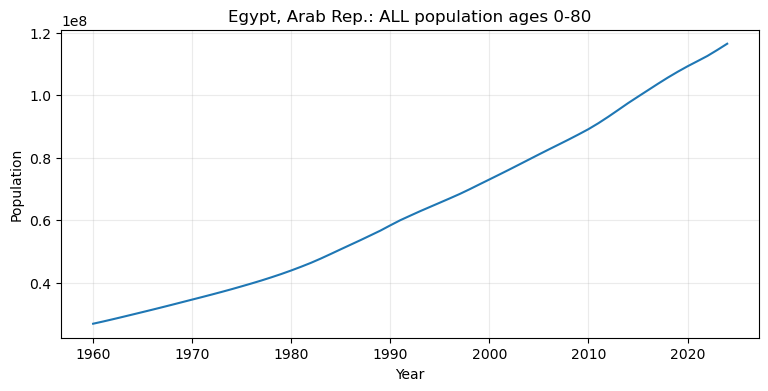

Egypt: 73083285.0


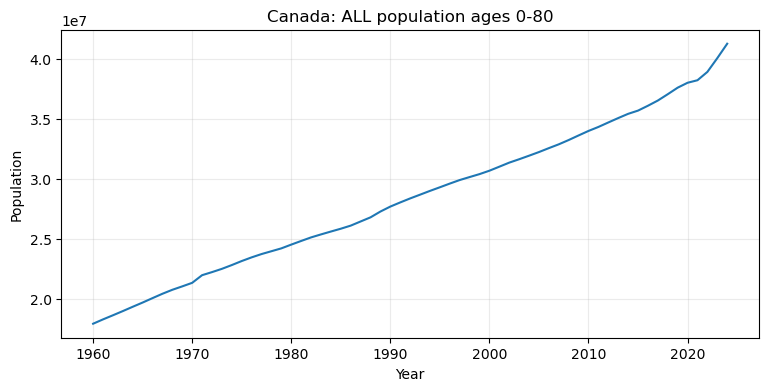

Canada: 30685733.0


#### 3. [B] Static Population Pyramids (with water/ag annotations)

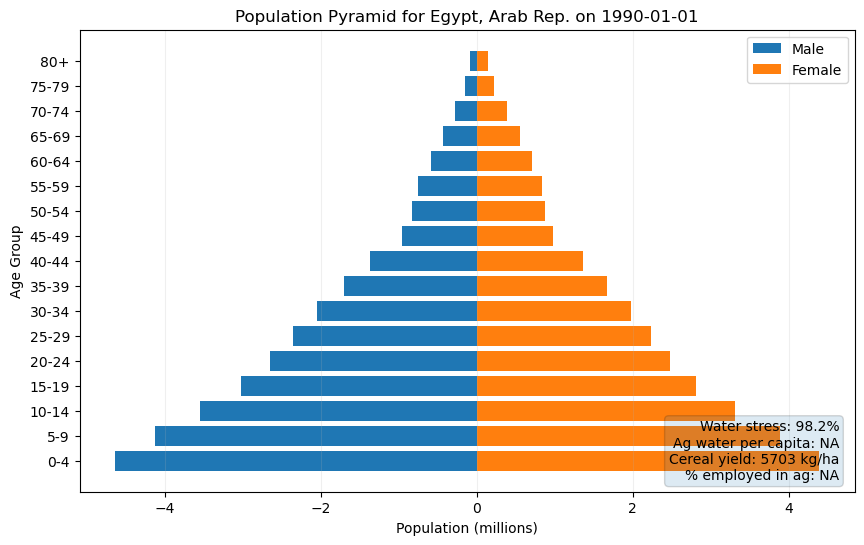

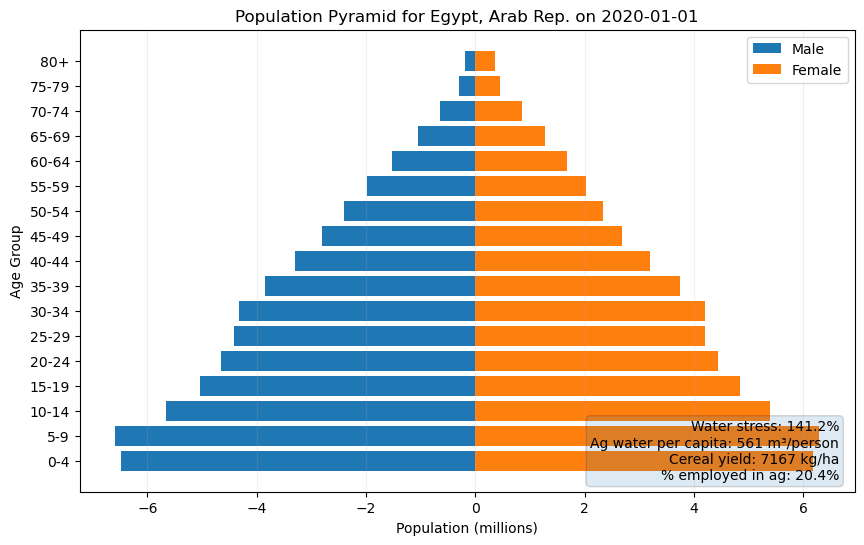

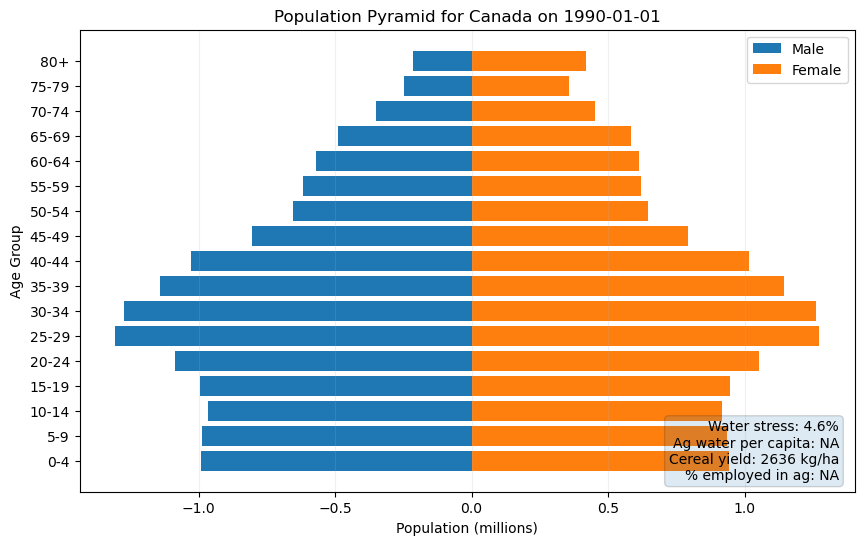

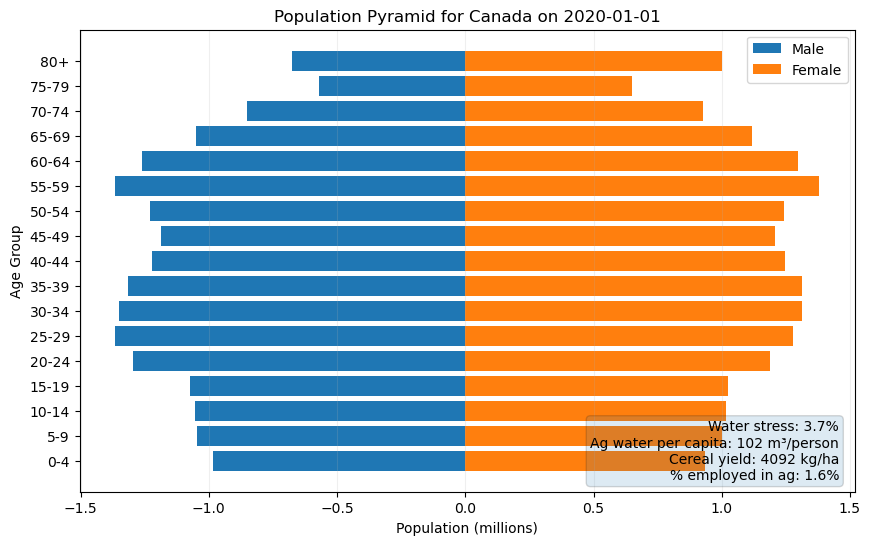

#### 4. [C] Animated Population Pyramids (Plotly)

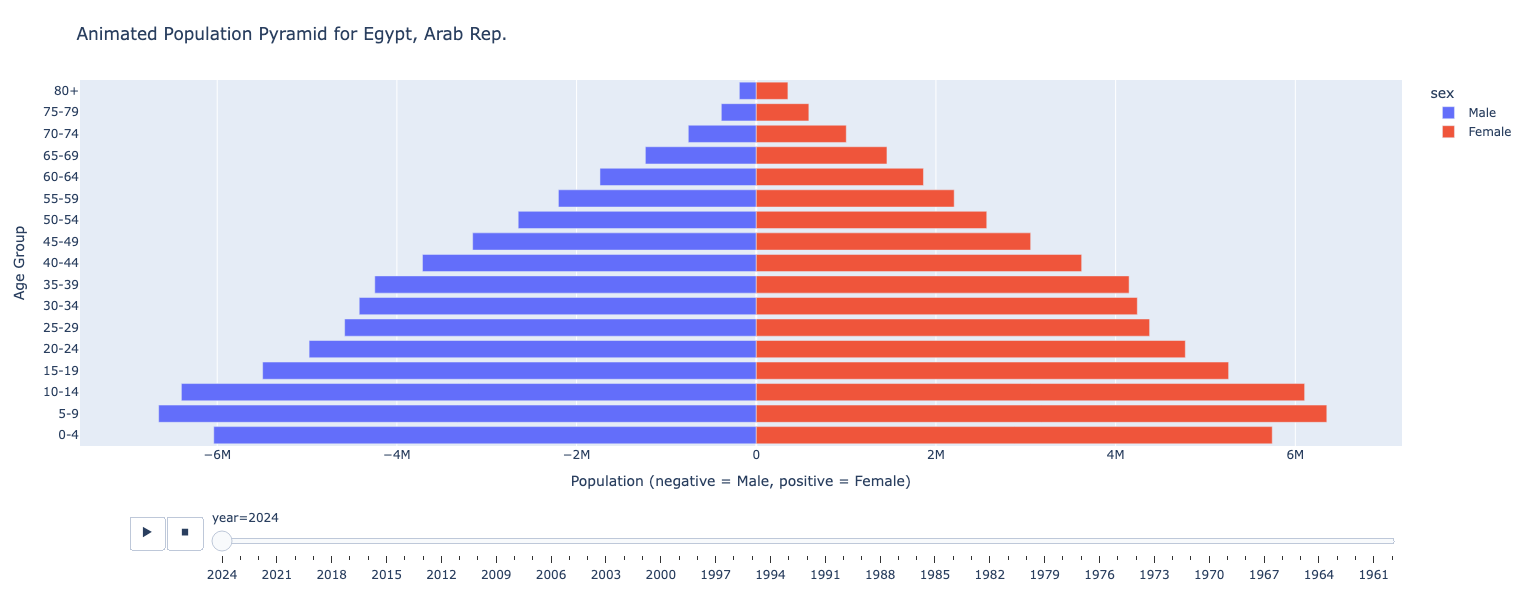

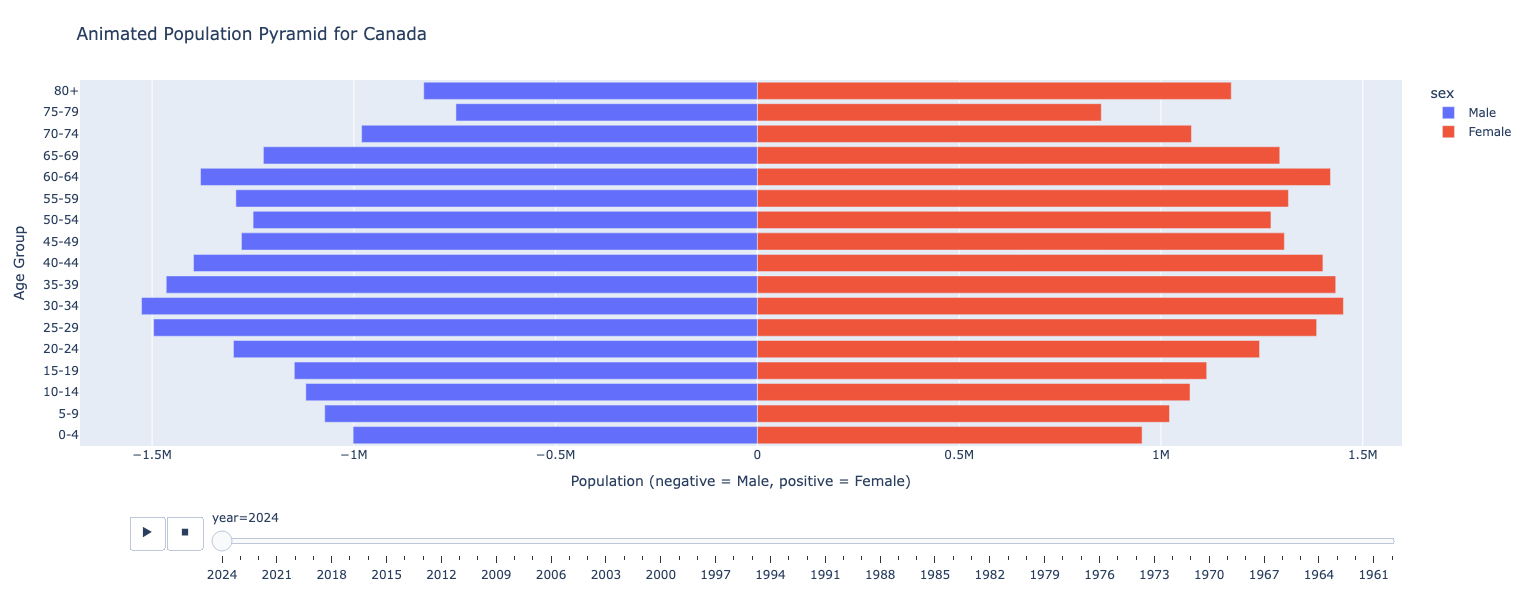

#### 5. [C] Population Maps

/tmp/ipykernel_8668/3590684151.py:22: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



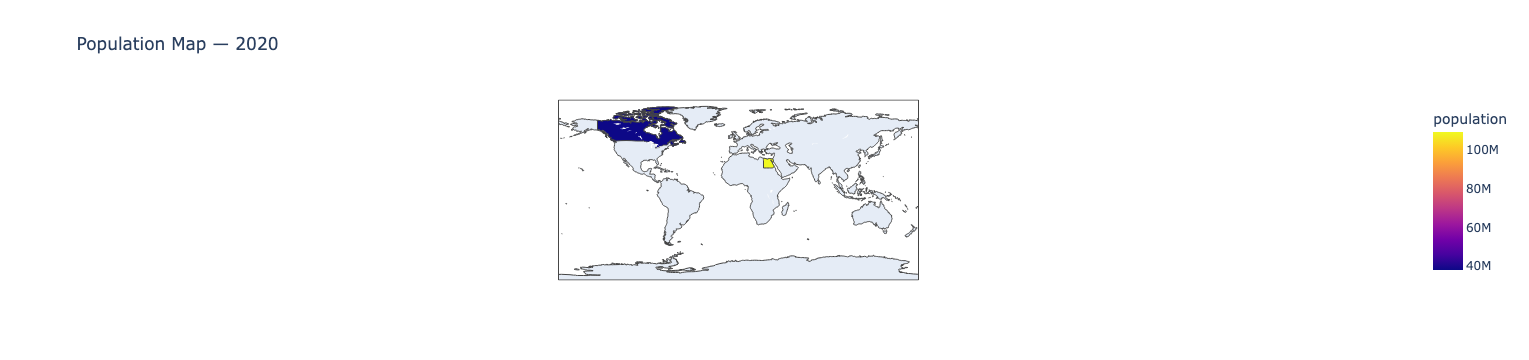

In [11]:
# Table of Contents

display(Markdown("""
# Deliverables and Functions
This notebook contains the functions we have used and the deliverables we have completed.

## Table of Contents
1. [A] [Population Statistics](#1-a-population-statistics)  
2. [A] [Population DataFrames](#2-a-population-dataframes)  
3. [B] [Population Pyramids](#3-b-population-pyramids)  
4. [C] [Animated Population Pyramids](#4-c-animated-population-pyramids)  
5. [C] [Population Maps](#5-c-population-maps)  
6. [C] [Other Visualization Tools](#6-c-other-visualization-tools)
"""))

COUNTRIES = {
    "EGY": "Egypt (water-scarce)",
    "CAN": "Canada (water-abundant)"
}

display(Markdown("#### 2. [A] Population DataFrames"))
POP_DF = get_population_by_age_sex(COUNTRIES)
display(POP_DF.head())

display(Markdown("#### Water/Ag Panel (for annotations)"))
WATER_DF = get_water_ag_panel(COUNTRIES)
display(WATER_DF.head())

display(Markdown("#### 1. [A] Population Statistics"))
print("Egypt:", population(2000, "ALL", [0, 80], "Egypt, Arab Rep.", graph=True, pop_df=POP_DF))
print("Canada:", population(2000, "ALL", [0, 80], "Canada", graph=True, pop_df=POP_DF))

display(Markdown("#### 3. [B] Static Population Pyramids (with water/ag annotations)"))
plot_population_pyramid(POP_DF, "Egypt, Arab Rep.", "1990-01-01", water_df=WATER_DF)
plot_population_pyramid(POP_DF, "Egypt, Arab Rep.", "2020-01-01", water_df=WATER_DF)

plot_population_pyramid(POP_DF, "Canada", "1990-01-01", water_df=WATER_DF)
plot_population_pyramid(POP_DF, "Canada", "2020-01-01", water_df=WATER_DF)


display(Markdown("#### 4. [C] Animated Population Pyramids (Plotly)"))
fig = animated_population_pyramid_wide(POP_DF, "Egypt, Arab Rep.", animate_by="year")
fig.show()

fig = animated_population_pyramid_wide(POP_DF, "Canada", animate_by="year")
fig.show()


display(Markdown("#### 5. [C] Population Maps"))
popmap_total_population(COUNTRIES, year=2020)